In [255]:
import numpy as np
import pandas as pd
import pymongo
from pymongo import MongoClient
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# import json
import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('ggplot')

from datetime import datetime
import boto3
import os
import time
import subprocess

In [42]:
from data.get_data import get_download_links

links_df = get_download_links()
links_df.head(20)

,month,link,downloaded,size_in_bytes,comment_count
0,2005-12,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
1,2006-01,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
2,2006-02,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
3,2006-03,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
4,2006-04,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
5,2006-05,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
6,2006-06,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
7,2006-07,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
8,2006-08,https://files.pushshift.io/reddit/comments/RC_...,False,0,0
9,2006-09,https://files.pushshift.io/reddit/comments/RC_...,False,0,0


In [196]:
def calculate_polarity(month, analyzer='sia'):
    """Calculate the polarity of each comment within a month. Update mongodb 
    collection with this data point."""

    
    client = MongoClient()
    db = client['myreddit']
    collection_name = 'comments-' + month
    collection = db[collection_name]
    
    cursor = collection.find({'$and': 
                                   [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                    {'$expr': {'$gt': ['$score', 0]}}]
                           })

    if analyzer == 'sia':
        sia = SIA()
        for doc in cursor:
            _id = doc['_id']
            body = doc['body']
            sentiment = sia.polarity_scores(body)['compound']
            collection.update_one({"_id": _id}, {"$set": {"vader_sentiment": sentiment}})
    elif analyzer == 'textblob':
        for doc in cursor:
            _id = doc['_id']
            body = doc['body']
            sentiment = TextBlob(body).sentiment.polarity
            collection.update_one({"_id": _id}, {"$set": {"textblob_sentiment": sentiment}})
    else:
        raise Error('Invalid analyzer selected')

    client.close()

In [ ]:
for idx, row in links_df.loc[20:143].iterrows():
    month = row['month']

    print('{}:\t{}'.format(idx,month), end='   ')
    start = time.time()
    calculate_polarity(month, analyzer='textblob')
    print('Done in {:1.1f} seconds'.format(time.time() - start))

20:	2007-08   Done in 3.0 seconds
21:	2007-09   Done in 5.1 seconds
22:	2007-10   Done in 8.4 seconds
23:	2007-11   Done in 12.3 seconds
24:	2007-12   Done in 16.9 seconds
25:	2008-01   Done in 22.3 seconds
26:	2008-02   

In [249]:
def monthly_stats(month, subreddit=None, analyzer='vader'):
    """Returns the average absolute sentiment polarity of a comment within a given month."""

    client = MongoClient()
    db = client['myreddit']
    collection_name = 'comments-' + month
    collection = db[collection_name]
    
    if subreddit == None:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}}]
                                })
    else:
        cursor = collection.find({'$and': 
                                       [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                        {'$expr': {'$gt': ['$score', 0]}},
                                        {'subreddit': subreddit}]
                                })
    
    total_n_words = 0
    total_abs_polarity = 0
    total_abs_weighted_polarity = 0
    total_score = 0
    comment_count = 0
    for doc in cursor:
        try:
            total_n_words += len(doc['body'].split())
        except:
            pass
        if analyzer == 'vader':
            total_abs_weighted_polarity += doc['score']*abs(doc['vader_sentiment'])
            total_abs_polarity += abs(doc['vader_sentiment'])
        else:
            total_abs_weighted_polarity += doc['score']*abs(doc['textblob_sentiment'])
            total_abs_polarity += abs(doc['textblob_sentiment'])
        total_score += doc['score']
        comment_count += 1

    try:
        avg_abs_weighted_polarity = total_abs_weighted_polarity/total_score
    except ZeroDivisionError:
        avg_abs_weighted_polarity = None

    try:
        avg_abs_polarity = total_abs_polarity/comment_count
    except ZeroDivisionError:
        avg_abs_polarity = None

    try:
        avg_wordcount = total_n_words/comment_count
    except ZeroDivisionError:
        avg_wordcount = None

    client.close()

    return {'avg_abs_wght_pol': avg_abs_weighted_polarity, 
            'avg_abs_pol': avg_abs_polarity,
            'comment_count': comment_count, 
            'avg_wordcount': avg_wordcount}

In [250]:
def get_sentiment(m_start, m_end, df, subreddit=None, analyzer='vader'):

    d = {}
    for idx, row in df.loc[m_start:m_end].iterrows():
        month = row['month']
        if idx % 10 == 0:
            print(idx, month)
        d[month] = monthly_stats(month, subreddit=subreddit, analyzer=analyzer)

    return d

In [244]:
def monthly_stats_top_posts(yearmonths, subreddit, post_limit=100, analyzer='vader'):
    """Gets specific stats for all comments among the top (post_limit) posts."""
    
    client = MongoClient()
    db = client['myreddit']
    posts_all = db['posts_all']

    cursor = posts_all.find({'yearmonth': yearmonths[0], 'sub': subreddit}).sort('score', pymongo.DESCENDING).limit(post_limit)
    link_ids = [post['link_id'] if post['link_id'].startswith('t3_') else 't3_' + post['link_id'] for post in cursor]

    total_n_words = 0
    total_abs_weighted_polarity = 0
    total_abs_polarity = 0
    total_score = 0
    total_wordcount = 0
    comment_count = 0

    for ym in yearmonths:
        coll_name = 'comments-' + ym
        coll = db[coll_name]
        cursor = coll.find({'$and': 
                                [{'$expr': {'$ne': ['$body', '[deleted]']}},
                                 {'$expr': {'$gt': ['$score', 0]}},
                                 {'link_id': {'$in': link_ids}}]
                            })
        for doc in cursor:
            try:
                total_n_words += len(doc['body'].split())
            except:
                pass
            if analyzer == 'vader':
                total_abs_weighted_polarity += doc['score']*abs(doc['vader_sentiment'])
                total_abs_polarity += abs(doc['vader_sentiment'])
            else:
                total_abs_weighted_polarity += doc['score']*abs(doc['textblob_sentiment'])
                total_abs_polarity += abs(doc['textblob_sentiment'])
            total_score += doc['score']
            comment_count += 1
    
    client.close()

    try:
        avg_abs_weighted_polarity = total_abs_weighted_polarity/total_score
    except ZeroDivisionError:
        avg_abs_weighted_polarity = None

    try:
        avg_abs_polarity = total_abs_polarity/comment_count
    except ZeroDivisionError:
        avg_abs_polarity = None

    try:
        avg_wordcount = total_n_words/comment_count
    except ZeroDivisionError:
        avg_wordcount = None
    
    return {'avg_abs_wght_pol': avg_abs_weighted_polarity, 
            'avg_abs_pol': avg_abs_polarity,
            'comment_count': comment_count, 
            'avg_wordcount': avg_wordcount}

In [257]:
import statsmodels.api as sm

def make_trend_line(series):
    X = sm.add_constant((np.arange(len(series)) + 1).reshape(-1, 1), prepend=False)
#     series = series.reshape(-1, 1)
    linear_trend_ols = sm.OLS(series, X).fit()
    return linear_trend_ols.predict(X)

In [258]:
def plot_stats(data_dict, title, axes):
    fig.suptitle(title, fontsize=16)

    dates = [datetime.strptime(k, '%Y-%m') for k, _ in sorted(data_dict.items())]
    aawp = [v['avg_abs_wght_pol'] for _, v in sorted(data_dict.items())]
    aap = [v['avg_abs_pol'] for _, v in sorted(data_dict.items())]
    ccnt = [v['comment_count'] for _, v in sorted(data_dict.items())]
    awc = [v['avg_wordcount'] for _, v in sorted(data_dict.items())]

    axes[0].plot(dates, aawp)
    aawp_trendline = make_trend_line(aawp)
    axes[0].plot(dates, aawp_trendline)
    axes[0].set_title('Absolute Weighted Comment Polarity')
    axes[1].plot(dates, aap)
    axes[1].set_title('Absolute Comment Polarity')
    axes[2].plot(dates, ccnt)
    axes[2].set_title('Comment Count')

    axes[2].set_yscale('log')
    axes[2].yaxis.set_major_formatter(ScalarFormatter())

In [230]:
comment_thresh = 5000

politics_data_textblob = get_sentiment(20, 143, links_df, subreddit='politics', analyzer='textblob')
politics_data_textblob = {k: v for k, v in politics_data_textblob.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


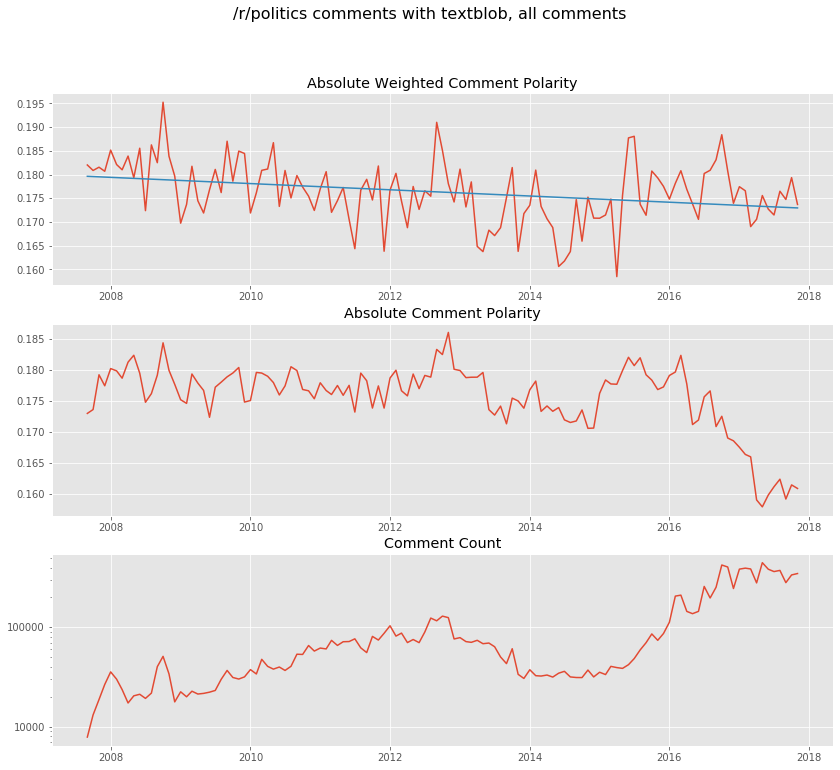

In [259]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_stats(politics_data_textblob, '/r/politics comments with textblob, all comments', axes)

In [261]:
comment_thresh = 5000

politics_data_textblob_pos = get_sentiment(20, 143, links_df, subreddit='politics', analyzer='textblob')
politics_data_textblob_pos = {k: v for k, v in politics_data_textblob_pos.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


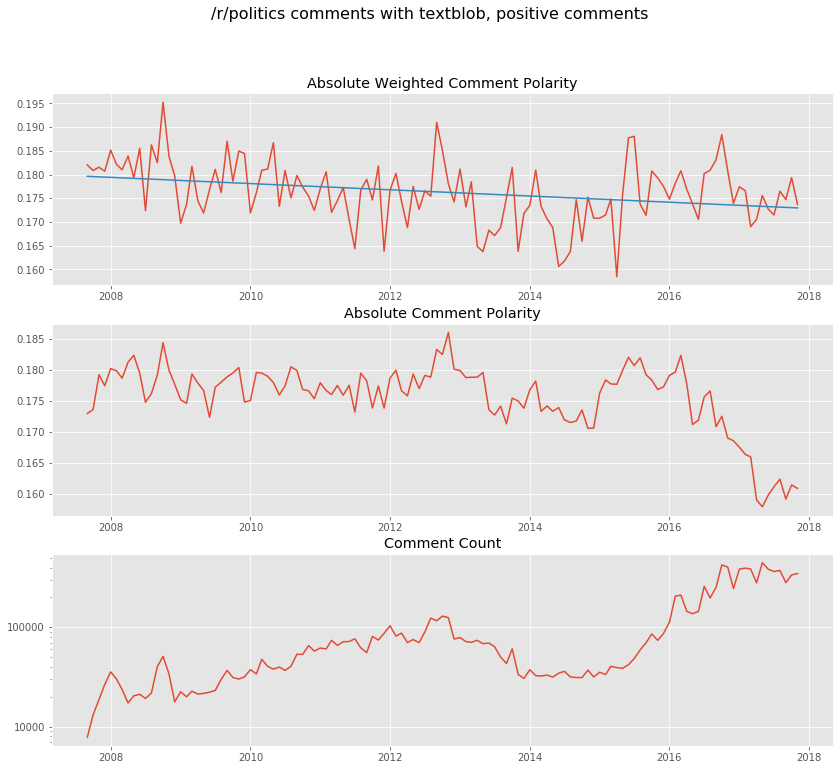

In [270]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_stats(politics_data_textblob_pos, '/r/politics comments with textblob, positive comments', axes)

In [ ]:
comment_thresh = 5000

politics_data_pos_vader = get_sentiment(20, 140, links_df, subreddit='politics', analyzer='vader')
politics_data_pos_vader = {k: v for k, v in politics_data_pos_vader.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_stats(politics_data_pos_vader, '/r/politics comments with vader, pos comments', axes)

In [267]:
comment_thresh = 5000

worldnews_data = get_sentiment(20, 140, links_df, subreddit='worldnews')
worldnews_data = {k: v for k, v in worldnews_data.items() if v['comment_count'] > comment_thresh}

20 2007-08
30 2008-06
40 2009-04
50 2010-02
60 2010-12
70 2011-10
80 2012-08
90 2013-06
100 2014-04
110 2015-02
120 2015-12
130 2016-10
140 2017-08


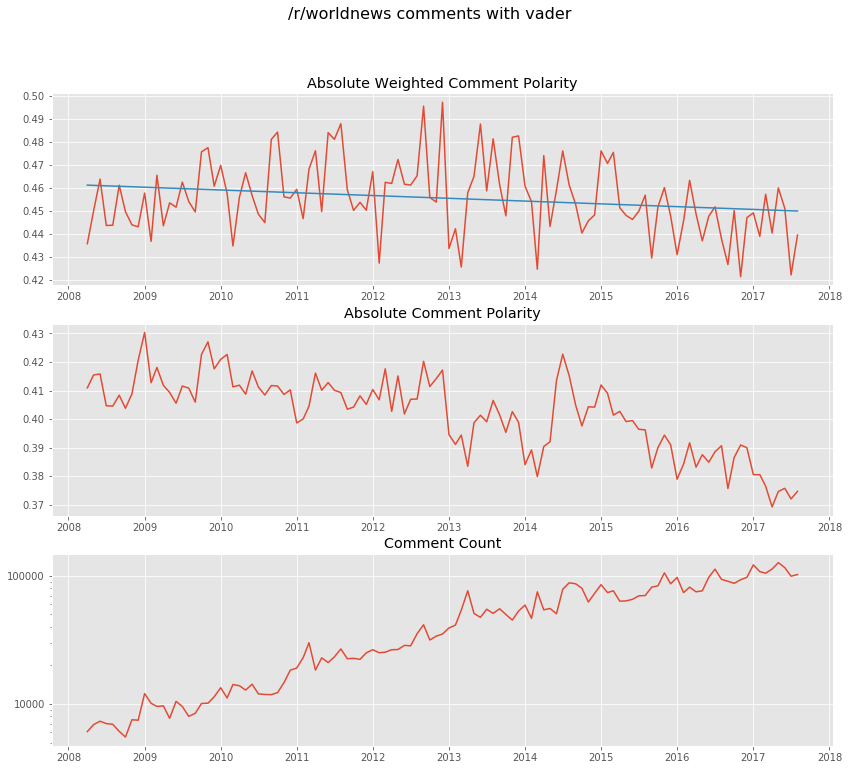

In [268]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_stats(worldnews_data, '/r/worldnews comments with vader', axes)

In [ ]:
comment_thresh = 5000

worldnews_data = get_sentiment(20, 140, links_df, subreddit='worldnews')
worldnews_data = {k: v for k, v in worldnews_data.items() if v['comment_count'] > comment_thresh}

1. Group posts by month. Make new 'datetime' field
2. Get top 100 posts for month
3. Look at comment sentiment for those posts

In [237]:
top_50_vader = {}
yearmonths = sorted(posts_all.distinct('yearmonth'))
for idx in range(len(yearmonths) - 1):
    # Get top 100 posts
    results = monthly_stats_top_posts(yearmonths[idx:idx+2], 'politics', post_limit=50)
    top_50_vader[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


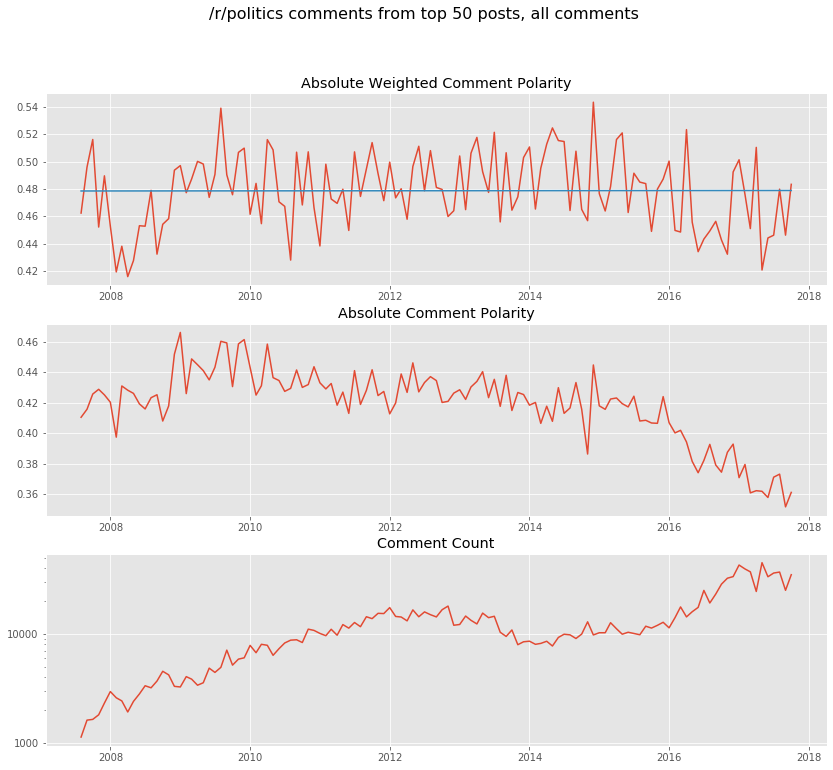

In [262]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_stats(top_50_vader, '/r/politics comments from top 50 posts, all comments', axes)

In [263]:
top_50_vader_pos = {}
yearmonths = sorted(posts_all.distinct('yearmonth'))
for idx in range(len(yearmonths) - 1):
    # Get top 100 posts
    results = monthly_stats_top_posts(yearmonths[idx:idx+2], 'politics', post_limit=50)
    top_50_vader_pos[yearmonths[idx]] = results
    if idx % 20 == 0:
        print(yearmonths[idx])

2007-08
2009-04
2010-12
2012-08
2014-04
2015-12
2017-08


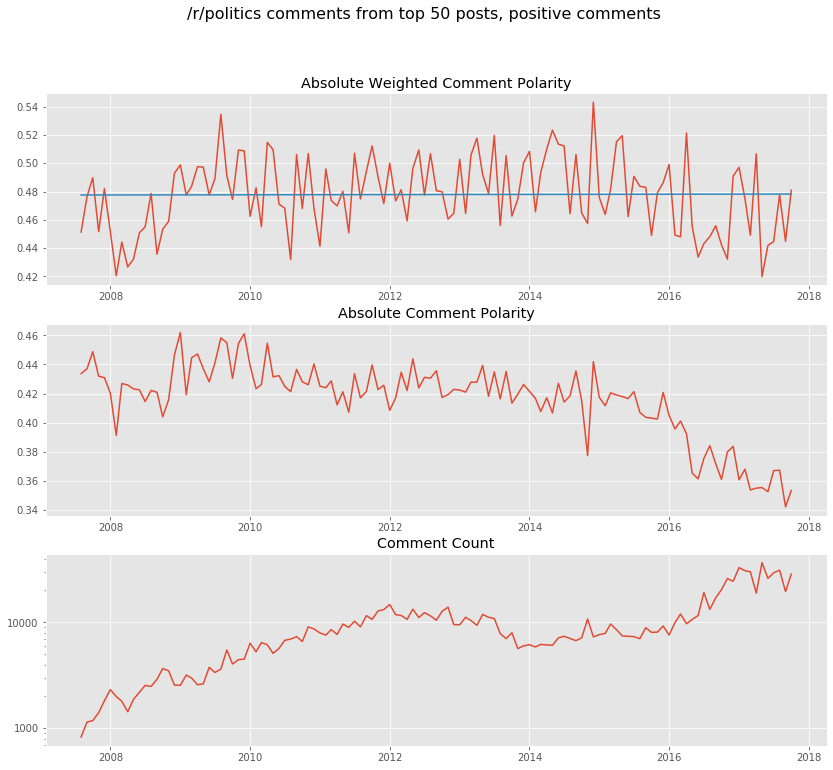

In [265]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
plot_stats(top_50_vader_pos, '/r/politics comments from top 50 posts, positive comments', axes)

In [160]:
def get_n_comments(db):
    """Gets number of comments across all months"""

    n_comments = 0
    for name in sorted([x for x in db.collection_names() if x.startswith('comments')]):
        coll = db[name]
        n_comments += coll.count()

    return n_comments